In [1]:
from cirq import *
from numpy import pi
import numpy as np
from numpy.random import randint as rnd
from multiprocessing import Pool as pool
from os import cpu_count as ncpu
from matplotlib import pyplot as plt
from tqdm import tqdm
from scipy.optimize import curve_fit


In [2]:
def parallel_cycle(set,func):
    with pool(ncpu()) as p:
        out = p.map(func,set)
    return out

In [26]:
def rotation_gate(theta):
    return np.array([[np.cos(theta/2),-np.sin(theta/2)],[np.sin(theta/2),np.cos(theta/2)]])


def singlet_creator(phase:float):
    a_direction = rnd(0,3)
    b_direction = rnd(1,4)
    a, b = LineQubit.range(2)
    
    circuit = Circuit(X(a),X(b),\
          H(a),\
          ZPowGate(exponent=phase/pi,global_shift=0).on(a),\
          CX(a,b),\
          MatrixGate(rotation_gate(a_direction*pi/4)).on(a),\
          MatrixGate(rotation_gate(b_direction*pi/4)).on(b),\
          measure(a,key="Alice"), measure(b,key="Bob"))
    return circuit ,a_direction,b_direction

In [39]:
singlet_creator(phase=0)

(                        ┌             ┐
0: ───X───H───Z^0───@───│ 0.707 -0.707│───M('Alice')───
                    │   │ 0.707  0.707│
                    │   └             ┘
                    │
                    │   ┌             ┐
1: ───X─────────────X───│ 0.924 -0.383│───M('Bob')─────
                        │ 0.383  0.924│
                        └             ┘,
 2,
 1)

In [4]:
def circuit_list_maker(n_states:int,phase:float):
    theta = [phase for k in range(n_states)]
    circuit_list = parallel_cycle(theta,singlet_creator)
    del theta
    return circuit_list

In [5]:


def simulation(circuit):
    simulator = Simulator()
    return simulator.run(circuit)

def probability_anticorrelation(measurement_information:list,n_states:int):
    N_coincident_basis = 0
    N_anticorrelations = 0
    
    for k in range(n_states):
        if measurement_information[k][0] == measurement_information[k][1]:
            N_coincident_basis +=1
            if int(bool(measurement_information[k][2])) == int(not bool(measurement_information[k][3])):
                N_anticorrelations +=1
            else:
                pass
        else:
            pass
    return N_anticorrelations/N_coincident_basis
#--------------------------------------------------------------------

def local_run(n_states:int,n_execs:int):
    phase_list = np.linspace(0,2*pi,n_execs)
    probability_list = list()
    for k in tqdm(range(n_execs),desc="Execution"):
        circuit_list = circuit_list_maker(n_states=n_states,phase=phase_list[k])
        circuits = [circuit_list[k][0] for k in range(n_states)]
        measurement_information = [[circuit_list[k][1],circuit_list[k][2],0,0] for k in range(n_states) ]
        del circuit_list
        
        with pool(ncpu()) as p:
            result_list = p.map(simulation,circuits)
        for k in range(n_states):
            measurement_information[k][2] = result_list[k].data.iloc[0,0]
            measurement_information[k][3] = result_list[k].data.iloc[0,1]
        del result_list
        probability_list.append(probability_anticorrelation(measurement_information=measurement_information,n_states=n_states))
    return phase_list,probability_list
        

In [6]:
def func_fit(x,A:float,w:float,d:float,b:float):
    return A * np.cos(w*x + d) + b

def r2(y_exp,y_fit):
    Dy = y_exp - y_fit
    Dy2_sum = np.sum(Dy**2)
    tot_sum = np.sum((y_exp-np.mean(y_exp))**2)
    return 1. - (Dy2_sum/tot_sum)

def fit(theta:list,fidelity:list):
    popt, pcov = curve_fit(func_fit,theta,fidelity)
    r_squared_fit = r2(func_fit(theta,*popt),func_fit(theta,0.25,1.,0.,5/12))
    formula = f"Fit -> $P(\\theta) = {popt[0]:1.4f} \cos( {popt[1]:1.4f} \\theta + {popt[2]:1.4e} ) + {popt[3]:1.4f} $"
    print(formula)
    print(f"R^2 = {r_squared_fit}")
    return popt


def plots(theta:list,fidelity,popt:list):
    plt.plot(theta,fidelity,'.r',label="exp data")
    plt.plot(theta,func_fit(theta,*popt),'--k', label="fit")
    plt.plot(theta,func_fit(theta,0.25,1.,0.,5/12),'-b',label="theoretical")

    plt.legend(loc="lower left")
    plt.show()

<>:13: SyntaxWarning: invalid escape sequence '\c'
<>:13: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_11883/3536425032.py:13: SyntaxWarning: invalid escape sequence '\c'
  formula = f"Fit -> $P(\\theta) = {popt[0]:1.4f} \cos( {popt[1]:1.4f} \\theta + {popt[2]:1.4e} ) + {popt[3]:1.4f} $"


In [7]:
m = np.array(local_run(n_states=int(1e4/5),n_execs=20))
theta = m[0,:]
probability = m[1,:]



Execution: 100%|██████████| 20/20 [01:04<00:00,  3.22s/it]


Fit -> $P(\theta) = 0.2539 \cos( 1.0017 \theta + -6.2605e-03 ) + 0.7484 $
R^2 = -2.274524201137654


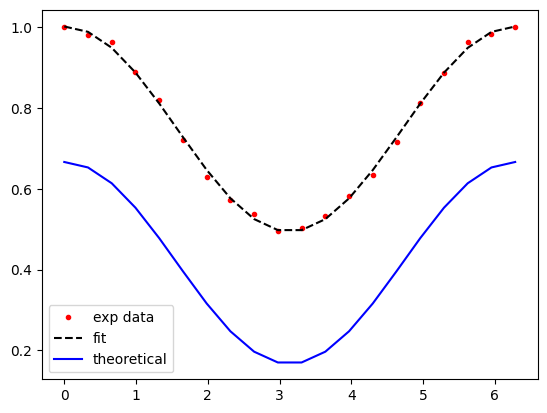

In [8]:
popt = fit(theta,probability)
plots(theta,probability,popt)